# Matching Games Franchises

Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import ast # used to convert strings to lists
import time
from rapidfuzz import process, fuzz

We can pick what we consider to be a franchise. At the moment, any franchise that is smaller than the number below will be excluded. We'll also set the value for our best_fit_ratio. At this stage, you won't know what it is, but having it here, allows us to easily change it later if necessary

In [62]:
minimum_franchise_value = 3
considered_best_fit_ratio = 92.5

First, read in the imdb data and the giantbomb data as dataframes and get a count

In [5]:
imdb_games = pd.read_csv("raw_data\imdb_games_db.csv", index_col = 0)
giantbomb_games = pd.read_csv("clean_data\clean_giantbomb_games_db.csv", index_col = 0)

In [6]:
print("Total imdb_games: {} \nTotal giantbomb_games: {}".format(imdb_games.shape[0], giantbomb_games.shape[0]))

Total imdb_games: 14572 
Total giantbomb_games: 35117


We'll remove any exact duplicates from both dataframes

In [7]:
imdb_games = imdb_games.drop_duplicates()
giantbomb_games = giantbomb_games.drop_duplicates()
print("Total imdb_games: {} \nTotal giantbomb_games: {}".format(imdb_games.shape[0], giantbomb_games.shape[0]))

Total imdb_games: 14572 
Total giantbomb_games: 35116


Have a look at what our dataframes contain:

In [8]:
imdb_games.sample()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,akas
3447066,tt14529054,videoGame,Final Fantasy Chronicles,Final Fantasy Chronicles,0,2001,\N,\N,"Action,Adventure,Comedy",6.9,14.0,['Final Fantasy Chronicles']


In [9]:
giantbomb_games.sample()

,franchise_id,game_id,name,release_year,aliases,developers,genres,platforms,publishers,rating
23601,3025-452,13974,Pokémon Mystery Dungeon: Blue/Red Rescue Team,NaN,Pokemon Mystery Dungeon: Blue/Red Rescue Team,['Chunsoft'],"['Role-Playing', 'Real-Time Strategy']","['Game Boy Advance', 'Nintendo DS', 'Wii U']","['Nintendo', 'The Pokémon Company']","['ESRB: E', 'OFLC: G', 'PEGI: 3+', 'CERO: A']"


### Remove imdb duplicates

We want to remove any duplicates from our imdb data that contain the same name and year. We save the one with the highest number of votes

In [10]:
imdb_games = imdb_games.sort_values(by=["primaryTitle", "startYear", "numVotes"])
imdb_games = imdb_games.drop_duplicates(subset=["primaryTitle", "startYear"], keep="last")
imdb_games.tconst.count()

14521

In [11]:
imdb_games.primaryTitle[imdb_games.duplicated(["primaryTitle", "startYear"], keep=False)].count()

0

### Remove giantbomb duplicates

As each game_id is unique, we want to group all the franchises for each game into a single result for each game_id. First though we check whether any of the the rows have the same game_id but a different name or release_year

In [12]:
giantbomb_games.count()

franchise_id    35116
game_id         35116
name            35116
release_year     5435
aliases          8088
developers      32746
genres          33660
platforms       34802
publishers      33604
rating          14184
dtype: int64

In [13]:
print(giantbomb_games.groupby("game_id").filter(lambda x: x["name"].nunique() > 1 or x["release_year"].nunique() > 1)["game_id"].count())

0


The next thing will be to remove any franchises which only contain 1 or 2 entries. Though they may technically count as a franchise, they do nothing to help us with analysis on the basis of longevity so we'll treat them as if they don't belong in a franchise

In [14]:
giantbomb_games.game_id.count()

35116

In [15]:
# Note: minimum_franchise_value is set at the top of the notebook
franchise_counts = giantbomb_games.groupby('franchise_id').size()
franchise_dict = {k:v for k,v in franchise_counts.items() if v < minimum_franchise_value}
franchise_ids_to_drop = list(franchise_dict.keys())

mask = giantbomb_games['franchise_id'].isin(franchise_ids_to_drop)
giantbomb_games = giantbomb_games.drop(index=giantbomb_games[mask].index)

In [16]:
giantbomb_games.count()

franchise_id    31529
game_id         31529
name            31529
release_year     4668
aliases          7423
developers      29402
genres          30205
platforms       31251
publishers      30282
rating          13149
dtype: int64

The first thing to do is to combine all the games that have an identical franchise_id, release_year and name. With this criteria we will assume they are all the same game released on different platforms for example. We want to consider the release_year even when it is a nan value, so we convert all nan values to 0 accommodate this. Once we've done this, we group by game_id to combine the franchises for each individual game

In [21]:
giantbomb_games

,franchise_id,game_id,name,release_year,aliases,developers,genres,platforms,publishers,rating
0,3025-1,544,Super Mario All-Stars & Super Mario World,1994.0,Super Mario All-Stars and Super Mario World,"['Nintendo EAD', 'SRD Co. Ltd.']","['Compilation', 'Platformer']",['Super Nintendo Entertainment System'],['Nintendo'],['ESRB: K-A']
1,3025-1,6649,Super Mario Sunshine,NaN,NaN,['Nintendo EAD'],"['Platformer', 'Action-Adventure']","['GameCube', 'Nintendo Switch']",['Nintendo'],"['ESRB: E', 'OFLC: G', 'PEGI: 3+']"
2,3025-1,7314,Super Mario Bros. Deluxe,NaN,Super Mario Bros. DX,['Nintendo R&D2'],"['Action', 'Adventure', 'Compilation', 'Puzzle...","['Game Boy Color', 'Nintendo 3DS eShop']",['Nintendo'],['ESRB: E']
3,3025-1,7358,Super Mario RPG: Legend of the Seven Stars,NaN,Mario RPG\r\nSMRPG,"['Squaresoft', 'Square Enix']","['Adventure', 'Role-Playing']","['Super Nintendo Entertainment System', 'Wii S...",['Nintendo'],"['ESRB: K-A', 'PEGI: 3+', 'ESRB: E', 'OFLC: G'..."
4,3025-1,7406,Super Mario Bros. 2,NaN,Super Mario USA\nSuper Mario Bros. USA\nSMB2,"['Nintendo EAD', 'SRD Co. Ltd.']",['Platformer'],"['Nintendo Entertainment System', 'Wii Shop', ...",['Nintendo'],"['ESRB: E', 'CERO: All Ages']"
...,...,...,...,...,...,...,...,...,...,...
35112,3025-999,26577,Shaman King: Funbari Spirits,NaN,NaN,['Dimps Corporation'],['Fighting'],['PlayStation 2'],"['Bandai Co., Ltd.']",NaN
35113,3025-999,26575,"Shaman King: Legacy of the Spirits, Soaring Hawk",NaN,NaN,NaN,['Role-Playing'],['Game Boy Advance'],['Konami'],NaN
35114,3025-999,26581,Shaman King Chou Senjiryokketsu: Meramera/Funb...,NaN,NaN,['Studio Saizensen'],['Action'],['Game Boy Color'],['King Records'],NaN
35115,3025-999,26580,Shaman King: Soul Fight!,NaN,NaN,"['Bandai Co., Ltd.']",['Fighting'],['GameCube'],"['Bandai Co., Ltd.']",NaN


In [22]:
giantbomb_games

,franchise_id,game_id,name,release_year,aliases,developers,genres,platforms,publishers,rating
0,3025-1,544,Super Mario All-Stars & Super Mario World,1994.0,Super Mario All-Stars and Super Mario World,"['Nintendo EAD', 'SRD Co. Ltd.']","['Compilation', 'Platformer']",['Super Nintendo Entertainment System'],['Nintendo'],['ESRB: K-A']
1,3025-1,6649,Super Mario Sunshine,NaN,NaN,['Nintendo EAD'],"['Platformer', 'Action-Adventure']","['GameCube', 'Nintendo Switch']",['Nintendo'],"['ESRB: E', 'OFLC: G', 'PEGI: 3+']"
2,3025-1,7314,Super Mario Bros. Deluxe,NaN,Super Mario Bros. DX,['Nintendo R&D2'],"['Action', 'Adventure', 'Compilation', 'Puzzle...","['Game Boy Color', 'Nintendo 3DS eShop']",['Nintendo'],['ESRB: E']
3,3025-1,7358,Super Mario RPG: Legend of the Seven Stars,NaN,Mario RPG\r\nSMRPG,"['Squaresoft', 'Square Enix']","['Adventure', 'Role-Playing']","['Super Nintendo Entertainment System', 'Wii S...",['Nintendo'],"['ESRB: K-A', 'PEGI: 3+', 'ESRB: E', 'OFLC: G'..."
4,3025-1,7406,Super Mario Bros. 2,NaN,Super Mario USA\nSuper Mario Bros. USA\nSMB2,"['Nintendo EAD', 'SRD Co. Ltd.']",['Platformer'],"['Nintendo Entertainment System', 'Wii Shop', ...",['Nintendo'],"['ESRB: E', 'CERO: All Ages']"
...,...,...,...,...,...,...,...,...,...,...
35112,3025-999,26577,Shaman King: Funbari Spirits,NaN,NaN,['Dimps Corporation'],['Fighting'],['PlayStation 2'],"['Bandai Co., Ltd.']",NaN
35113,3025-999,26575,"Shaman King: Legacy of the Spirits, Soaring Hawk",NaN,NaN,NaN,['Role-Playing'],['Game Boy Advance'],['Konami'],NaN
35114,3025-999,26581,Shaman King Chou Senjiryokketsu: Meramera/Funb...,NaN,NaN,['Studio Saizensen'],['Action'],['Game Boy Color'],['King Records'],NaN
35115,3025-999,26580,Shaman King: Soul Fight!,NaN,NaN,"['Bandai Co., Ltd.']",['Fighting'],['GameCube'],"['Bandai Co., Ltd.']",NaN


In [23]:
#Groupby franchise_id, year and name, fill empty years with 0, remove duplicates from all the columns
giantbomb_games = giantbomb_games.groupby(["name", "franchise_id", giantbomb_games["release_year"].fillna(0)]).agg({
    "aliases": lambda x: list(set(x)),
    "developers": lambda x: list(set(x)),
    "genres": lambda x: list(set(x)),
    "platforms": lambda x: list(set(x)),
    "publishers": lambda x: list(set(x)),
    "rating": lambda x: list(set(x)),
    "game_id": "first"
}).reset_index().drop_duplicates(["game_id", "name", "franchise_id", "release_year"], keep="first")

#Group all the games by game_id
giantbomb_games = giantbomb_games.groupby('game_id').agg({
    'franchise_id': lambda x: list(x),
    'name': 'first',
    'release_year': 'first',
    'aliases': 'first',
    'developers': 'first',
    'genres': 'first',
    "platforms": "first",
    "publishers" : "first",
    "rating": "first"
})

# Change year to string to match imdb database
giantbomb_games["release_year"] = giantbomb_games["release_year"].apply(lambda x : str(x).split('.')[0])

In [ ]:
giantbomb_games.sort_values("game_id")

We can now get a record of the number of duplicate names in the data

In [24]:
giantbomb_games.name[giantbomb_games.duplicated(["name"], keep=False)].count()

560

We can add the criteria to distinguish by both name and release year, which returns the following:

In [25]:
giantbomb_games.name[giantbomb_games.duplicated(["name", "release_year"], keep=False)].count()

72

We'll combine any duplicates in giantbomb which have the same name and release year

In [29]:
# group by name and release year, aggregate the franchise_id lists
giantbomb_games = giantbomb_games.groupby(['name', 'release_year'], as_index=False).agg({
    'franchise_id': lambda x: list(set([i for l in x for i in l])),
    'name': 'first',
    'release_year': 'first',
    "aliases": 'first',
    "developers": lambda x: list(set([i for l in x for i in l])),
    "genres": lambda x: list(set([i for l in x for i in l])),
    "platforms": lambda x: list(set([i for l in x for i in l])),
    "publishers" : lambda x: list(set([i for l in x for i in l])),
    "rating": lambda x: list(set([i for l in x for i in l]))
})

The release year needs to be converted to a string so we can compare it to the imdb database. We also need to tmove trailing decimal points.

In [30]:
giantbomb_games["release_year"] = giantbomb_games["release_year"].apply(lambda x : str(x).split('.')[0])

Reset the index so we have access to the game_ids

In [31]:
giantbomb_games = giantbomb_games.reset_index()
giantbomb_games = giantbomb_games.rename(columns={'index': 'game_id'})

In [32]:
giantbomb_games.sample()

,game_id,franchise_id,name,release_year,aliases,developers,genres,platforms,publishers,rating
15183,15183,[3025-463],Pac-Man: Special Color Edition,0,[nan],[['Namco']],[['Compilation']],[['Game Boy Color']],[['Namco']],[['ESRB: E']]


## Beginning to combine dataframes

In [33]:
def imdb_all_names(imdb_row):
    imdb_row_list = [imdb_row.primaryTitle, imdb_row.originalTitle]
    if type(imdb_row.akas) ==str:
        akas_list = ast.literal_eval(imdb_row.akas)
        for x in akas_list:
            imdb_row_list.append(x)
    return imdb_row_list

Create a row with all the possible names

In [34]:
imdb_games['all_names'] = imdb_games.apply(lambda row: imdb_all_names(row), axis=1)

Remove duplicates from all names and explode

In [35]:
imdb_games['all_names'] = imdb_games['all_names'].apply(lambda x: list(set(x)))

In [36]:
imdb_games = imdb_games.explode('all_names')

Do the same for giantbomb

In [37]:
def gb_all_names(gb_row):
    gb_row_list = [gb_row["name"]]
    for alias in gb_row.aliases:
        if type(alias) == str:
            gb_row_list.append(alias) 
    return gb_row_list

In [38]:
giantbomb_games['all_names'] = giantbomb_games.apply(lambda row: gb_all_names(row), axis=1)
giantbomb_games['all_names'] = giantbomb_games['all_names'].apply(lambda x: list(set(x)))

In [39]:
giantbomb_games = giantbomb_games.explode("all_names")
giantbomb_games_list = giantbomb_games.all_names.to_list()

In [41]:
def get_top_match(row):
    return process.extractOne(row.all_names, giantbomb_games_list)

In [42]:
time_at_start = time.perf_counter()
imdb_games['best_match'] = imdb_games.apply(lambda row: get_top_match(row), axis = 1)
time_at_end = time.perf_counter()
print(time_at_end - time_at_start)

2468.228805


In [43]:
imdb_games[['best_fit_title', 'best_fit_ratio', 'best_fit_game_id']] = imdb_games['best_match'].apply(lambda x: pd.Series([i for i in x]))
imdb_games

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,akas,all_names,best_match,best_fit_title,best_fit_ratio,best_fit_game_id
7337278,tt4354918,videoGame,#IDARB (It Draws a Red Box),#IDARB (It Draws a Red Box),0,2015,\N,\N,Action,5.8,25.0,['#IDARB (It Draws a Red Box)'],#IDARB (It Draws a Red Box),"(12 Labours of Hercules IX: A Hero's Moonwalk,...",12 Labours of Hercules IX: A Hero's Moonwalk,85.5,94
5072586,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ...",Konami '88,"(Konami '88\r\nHyper Sports Special, 90.0, 27)",Konami '88\r\nHyper Sports Special,90.0,27
5072586,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ...",'88 Games,"('88 Games, 100.0, 28)",'88 Games,100.0,28
5072586,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ...",Hyper Sports Special,"(Konami '88\r\nHyper Sports Special, 90.0, 27)",Konami '88\r\nHyper Sports Special,90.0,27
5072586,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ...",Track & Field '88,"(Track & Field, 95.0, 28468)",Track & Field,95.0,28468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295703,tt0308989,videoGame,ssn,ssn,0,1996,\N,\N,\N,7.9,13.0,['ssn'],ssn,"(N, 90.0, 16877)",N,90.0,16877
770416,tt0795512,videoGame,Æon Flux,Æon Flux,0,2005,\N,\N,"Action,Adventure,Sci-Fi",5.6,265.0,['Æon Flux'],Æon Flux,"(Bit.Trip Flux, 85.5, 2747)",Bit.Trip Flux,85.5,2747
2184438,tt1219283,videoGame,Îhatôvo monogatari,Îhatôvo monogatari,0,1993,\N,\N,Adventure,7.0,6.0,"['Ihatovo Story', 'Îhatôvo monogatari']",Ihatovo Story,"(ST, 90.0, 22746)",ST,90.0,22746
2184438,tt1219283,videoGame,Îhatôvo monogatari,Îhatôvo monogatari,0,1993,\N,\N,Adventure,7.0,6.0,"['Ihatovo Story', 'Îhatôvo monogatari']",Îhatôvo monogatari,(Shin Rorona no Atelier: Hajimari no Monogatar...,Shin Rorona no Atelier: Hajimari no Monogatari...,85.5,1764


In [1]:
# If desired, save the results of the matching here:
#imdb_games.to_csv("raw_imdb_games_matches.csv")

Drop any nan values for best_fit_ratio as these are problem entries where the titles are messed up

In [44]:
imdb_games = imdb_games[imdb_games['best_fit_ratio'].notna()]

Convert the game ids to ints

In [45]:
imdb_games["best_fit_game_id"] = imdb_games["best_fit_game_id"].apply(lambda x: int(x))

In [46]:
imdb_games.head(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,akas,all_names,best_match,best_fit_title,best_fit_ratio,best_fit_game_id
7337278,tt4354918,videoGame,#IDARB (It Draws a Red Box),#IDARB (It Draws a Red Box),0,2015,\N,\N,Action,5.8,25.0,['#IDARB (It Draws a Red Box)'],#IDARB (It Draws a Red Box),"(12 Labours of Hercules IX: A Hero's Moonwalk,...",12 Labours of Hercules IX: A Hero's Moonwalk,85.5,94
5072586,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ...",Konami '88,"(Konami '88\r\nHyper Sports Special, 90.0, 27)",Konami '88\r\nHyper Sports Special,90.0,27
5072586,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ...",'88 Games,"('88 Games, 100.0, 28)",'88 Games,100.0,28
5072586,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ...",Hyper Sports Special,"(Konami '88\r\nHyper Sports Special, 90.0, 27)",Konami '88\r\nHyper Sports Special,90.0,27
5072586,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,14.0,"[""Track & Field '88"", 'Hyper Sports Special', ...",Track & Field '88,"(Track & Field, 95.0, 28468)",Track & Field,95.0,28468


In [47]:
giantbomb_games.head(5)

,game_id,franchise_id,name,release_year,aliases,developers,genres,platforms,publishers,rating,all_names
0,0,"[3025-725, 3025-448]",2 Games In 1: LEGO Knights' Kingdom + LEGO Bi...,0,[nan],"[['Razorback Developments Ltd', 'Rockstar Leed...",[['Action']],[['Game Boy Advance']],[['THQ']],[nan],2 Games In 1: LEGO Knights' Kingdom + LEGO Bi...
1,1,[3025-647],Atelier Ryza 2: Lost Legends & the Secret Fairy,0,[nan],"[['GUST Co., Ltd.']]",[['Role-Playing']],"[['PC', 'PlayStation 4', 'Nintendo Switch', 'P...",[['Koei Tecmo']],"[['CERO: C', 'ESRB: T']]",Atelier Ryza 2: Lost Legends & the Secret Fairy
2,2,"[3025-1819, 3025-1691]",Electric Crayon 3.0: Inspector Gadget: Safety...,0,[nan],"[['Brian A. Rice, Inc.']]",[['Educational']],[['PC']],[['Merit Software']],[nan],Electric Crayon 3.0: Inspector Gadget: Safety...
3,3,[3025-3748],Empire Deluxe Combined Edition,0,[Empire Deluxe Masters Edition\nEmpire Deluxe ...,"[['White Wolf Productions', 'Killer Bee Softwa...",[['Strategy']],[['PC']],"[['New World Computing, Inc.', 'Killer Bee Sof...",[nan],Empire Deluxe Masters Edition\nEmpire Deluxe I...
3,3,[3025-3748],Empire Deluxe Combined Edition,0,[Empire Deluxe Masters Edition\nEmpire Deluxe ...,"[['White Wolf Productions', 'Killer Bee Softwa...",[['Strategy']],[['PC']],"[['New World Computing, Inc.', 'Killer Bee Sof...",[nan],Empire Deluxe Combined Edition


Remove the extra lists from the developers, genres, platforms, publishers and rating columns

In [48]:
giantbomb_games["developers"] = giantbomb_games["developers"].apply(lambda x: x[0])
giantbomb_games["genres"] = giantbomb_games["genres"].apply(lambda x: x[0])
giantbomb_games["platforms"] = giantbomb_games["platforms"].apply(lambda x: x[0])
giantbomb_games["publishers"] = giantbomb_games["publishers"].apply(lambda x: x[0])
giantbomb_games["rating"] = giantbomb_games["rating"].apply(lambda x: x[0])

Drop the index, so we can use the index from the exploded giantbomb dataframe (which will directly line up with the position in the list where the matches are made)

In [49]:
giantbomb_games = giantbomb_games.reset_index(drop = True)

Merge all the titles, taking the best fit for each game and applying to the imdb dataset

In [50]:
imdb_games = pd.merge(imdb_games, giantbomb_games,  left_on=["best_fit_game_id"], right_index=True, how="left")
imdb_games

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_x,averageRating,...,franchise_id,name,release_year,aliases,developers,genres_y,platforms,publishers,rating,all_names_y
7337278,tt4354918,videoGame,#IDARB (It Draws a Red Box),#IDARB (It Draws a Red Box),0,2015,\N,\N,Action,5.8,...,[3025-4692],12 Labours of Hercules IX: A Hero's Moonwalk,0,[nan],"['Jetdogs Studios', 'Zoom Out Games']","['Strategy', 'Puzzle']",['PC'],['Jetdogs Studios'],NaN,12 Labours of Hercules IX: A Hero's Moonwalk
5072586,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,...,[3025-1053],'88 Games,1988,[Konami '88\r\nHyper Sports Special],['Konami'],['Track & Field'],['Arcade'],['Konami'],NaN,Konami '88\r\nHyper Sports Special
5072586,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,...,[3025-1053],'88 Games,1988,[Konami '88\r\nHyper Sports Special],['Konami'],['Track & Field'],['Arcade'],['Konami'],NaN,'88 Games
5072586,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,...,[3025-1053],'88 Games,1988,[Konami '88\r\nHyper Sports Special],['Konami'],['Track & Field'],['Arcade'],['Konami'],NaN,Konami '88\r\nHyper Sports Special
5072586,tt1968978,videoGame,'88 Games,Hyper Sports Special,0,1988,\N,\N,Sport,6.0,...,"[3025-3709, 3025-1053]",Track & Field,1983,[Hyper Olympic\r\nTrack and Field\r\nKonamic S...,"['Konami', 'Atari', 'K-Byte']","['Sports', 'Track & Field']","['Game Boy', 'Apple II', 'Commodore 64', 'Nint...","['Konami', 'Atari', 'Centuri, Inc.', 'Gradiente']",['ESRB: E'],Track & Field
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295703,tt0308989,videoGame,ssn,ssn,0,1996,\N,\N,\N,7.9,...,[3025-870],N,0,[N-Game\r\nNNNNNNNNNNNNN],['Metanet Software'],['Platformer'],"['PC', 'Browser']",['Metanet Software'],NaN,N
770416,tt0795512,videoGame,Æon Flux,Æon Flux,0,2005,\N,\N,"Action,Adventure,Sci-Fi",5.6,...,[3025-1298],Bit.Trip Flux,0,[nan],['Choice Provisions'],['Music/Rhythm'],"['Wii Shop', 'PC']",['Aksys Games'],NaN,Bit.Trip Flux
2184438,tt1219283,videoGame,Îhatôvo monogatari,Îhatôvo monogatari,0,1993,\N,\N,Adventure,7.0,...,[3025-3153],Shining Tears,0,[ST],['Nex Entertainment'],"['Action', 'Role-Playing']",['PlayStation 2'],['Sega'],['ESRB: T'],ST
2184438,tt1219283,videoGame,Îhatôvo monogatari,Îhatôvo monogatari,0,1993,\N,\N,Adventure,7.0,...,[3025-647],Atelier Rorona Plus: The Alchemist of Arland,0,[Shin Rorona no Atelier: Hajimari no Monogatar...,"['GUST Co., Ltd.', 'Digital Hearts Co., Ltd. '...",['Role-Playing'],"['PlayStation 3', 'PlayStation Network (PS3)',...",['Koei Tecmo'],"['CERO: B', 'ESRB: T', 'OFLC: R18+']",Shin Rorona no Atelier: Hajimari no Monogatari...


Remove unneccessary columns

In [52]:
imdb_games = imdb_games.drop(columns = ["endYear", "best_match", "runtimeMinutes", "all_names_y", "aliases", "akas"])

Sort the values by tconst and best_fit_ratio. We then want to keep the highest best_fit for each tconst game

In [53]:
imdb_games = imdb_games.sort_values(["tconst", "best_fit_ratio"])
imdb_games = imdb_games.drop_duplicates(["tconst"], keep="last")

In [54]:
imdb_games.sample()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,genres_x,averageRating,numVotes,all_names_x,...,best_fit_game_id,game_id,franchise_id,name,release_year,developers,genres_y,platforms,publishers,rating
5570477,tt2174223,videoGame,Wizball,Wizball,0,1987,Action,6.1,18.0,Wizball,...,2059,1721,[3025-1183],Ball,0,['Nintendo'],['Action'],['DSiWare'],['Nintendo'],NaN


## Finding the most accurate match ratio

Now I need to remove any records where the best_fit_ratio is too low. I can examine some of the criteria. When looking at these, we compare all_names_x and best_fit_title as these are the 2 titles that the ratio is calculated on.

In [55]:
imdb_games.loc[imdb_games["best_fit_ratio"] >= 75, ["all_names_x", "best_fit_title", "best_fit_ratio"]].sort_values("best_fit_ratio").head(20)

,all_names_x,best_fit_title,best_fit_ratio
3323869,ALTF4,ALF,75.0
1910568,Boneworks,Bonkers,75.0
3476298,Deadbolt,Deadpool,75.0
2960253,Helltaker,Shelter,75.0
2353066,Suzerain,Superman,75.0
1280113,Misao,MSA,75.0
439130,Deadhunt,DreadOut,75.0
3423259,Unturned,Nocturne,75.0
5975516,Foreclosed,Forced,75.0
8167609,Owlboy,Frog Detective 3: Corruption at Cowboy County,75.0


At 75%, not one of our entries seems like a sensible match. We'll try with 85%

In [56]:
imdb_games.loc[imdb_games["best_fit_ratio"] >= 85, ["all_names_x", "best_fit_title", "best_fit_ratio"]].sort_values("best_fit_ratio").head(20)

,all_names_x,best_fit_title,best_fit_ratio
437263,Conquests of Camelot: The Search for the Grail,The Alto Collection,85.5
5269367,Beyond the Edge of Owlsgard,Atelier Ryza 2: Lost Legends & the Secret Fairy,85.5
2568316,So Blonde: Blondynka w opalach,428: Fuusa Sareta Shibuya de\r\n428: The World...,85.5
2573144,Rhodan: Myth of the Illochim,Atelier Ryza 2: Lost Legends & the Secret Fairy,85.5
3708340,Narcos: Rise of the Cartels,Atelier Ryza 2: Lost Legends & the Secret Fairy,85.5
2578363,Disaster: Day of Crisis,12 Labours of Hercules II: The Cretan Bull,85.5
7155884,Shingeki no kyojin: Hangeki no tsubasa Online,Minna no Golf Jou Vol. 4,85.5
2565347,Cyber Hunter,2 Games in 1 Double Pack: Scooby-Doo and the C...,85.5
7155881,Shingeki no kyojin: Hangeki no tsubasa,Minna no Golf Jou Vol. 4,85.5
300241,Temüjin: A Supernatural Adventure,1701 A.D.,85.5


Again, 85% seems to be too obscure. We'll up it to 90%

In [57]:
imdb_games.loc[imdb_games["best_fit_ratio"] >= 90, ["all_names_x", "best_fit_title", "best_fit_ratio"]].sort_values("best_fit_ratio").head(20)

,all_names_x,best_fit_title,best_fit_ratio
82552,"MysteryDisc: Murder, Anyone?",Myst,90.0
3595386,The Sims 4: StrangerVille,The Sims,90.0
3595363,The Sims 4: Island Living,The Sims,90.0
3595350,The Sims 4: Get Famous,The Sims,90.0
3595291,The Sims 4: Snowy Escape,The Sims,90.0
3595284,The Sims 4: City Living,The Sims,90.0
3595272,The Sims 4: Cats & Dogs,The Sims,90.0
3595258,The Sims 4: Get to Work,The Sims,90.0
3595403,The Sims 4: Vampires,The Sims,90.0
3579026,Sonic Colors: Ultimate,Sonic Colors,90.0


Approximately 6 of those 20 look like they could be a good match for the franchise, even if the game name is not the same (Notably the mafia ones for example). However this equates to a 30% accuracy, which I would not be happy with. 

In [58]:
imdb_games.loc[imdb_games["best_fit_ratio"] >= 92, ["all_names_x", "best_fit_title", "best_fit_ratio"]].sort_values("best_fit_ratio").head(17)

,all_names_x,best_fit_title,best_fit_ratio
3163545,SpongeBob's Atlantis SquarePantis,SpongeBob SquarePants: Atlantis Squarepantis,92.031250
5259571,Sword of the Stars 2: Lords of Winter,Sword of the Stars II: The Lords of Winter,92.031250
265594,Who Wants to Beat Up a Millionaire,Who Wants To Be A Millionaire,92.063492
259470,Hokuto no Ken: Seikimatsu kyûseishu densetsu,Hokuto no Ken: Seiki Matsukyu Seishi Densetsu,92.134831
8721767,Atelier Lydie & Suelle: Alchemists of the Myst...,Atelier Lydie & Suelle: The Alchemists and the...,92.187500
5541368,Toypop,Toy Pop,92.307692
8336860,Mario Kart 8DX,Mario Kart 8,92.307692
4856804,Flower,Flowers,92.307692
291504,Puzzle,Puzzled,92.307692
7093822,Tengami,Tengai,92.307692


At 92% ratio, around half of the games appear to be matching. By the time we up the ratio to 95% we are running with less than 10% mismatches (See below).

In [59]:
imdb_games.loc[imdb_games["best_fit_ratio"] >= 95, ["all_names_x", "best_fit_title", "best_fit_ratio"]].sort_values("best_fit_ratio").head(20)

,all_names_x,best_fit_title,best_fit_ratio
3603741,The Elder Scrolls Online: Blackwood,The Elder Scrolls Online,95.0
809470,Reader Rabbit,Reader Rabbit 2,95.0
8459265,Scooby Doo!: Frights Camera Mystery!,"Scooby Doo! Case File #3: Frights, Camera, Mys...",95.0
8459257,Scooby Doo: The Scary Stone Dragon,Scooby-Doo Case File #2: The Scary Stone Dragon,95.0
8459254,Scooby-Doo!: The Glowing Bug Man,Scooby-Doo: Case File #1: The Glowing Bug Man,95.0
8450968,Yo-kai Watch 2: Fleshy Souls,Yo-Kai Watch 2: Bony Spirits/Fleshy Souls,95.0
6949431,Nickelodeon Teenage Mutant Ninja Turtles,Teenage Mutant Ninja Turtles,95.0
420335,Duke Nukem 64,Duke Nukem,95.0
4681689,Battlefield: Bad Company 2 Vietnam,Battlefield: Bad Company,95.0
5951986,Mystery Case Files: The 13th Skull,Mystery Case Files: 13th Skull,95.0


At 93%, I'd estimate 17/20 in the correct classification, which is 85% accuracy.

In [60]:
imdb_games.loc[imdb_games["best_fit_ratio"] >= 93, ["all_names_x", "best_fit_title", "best_fit_ratio"]].sort_values("best_fit_ratio").head(20)

,all_names_x,best_fit_title,best_fit_ratio
1057033,Sam and Max Episode 104: Abe Lincoln Must Die!,Sam & Max Episode 4: Abe Lincoln Must Die!,93.023256
292626,Final Fantasy Legend 3,Final Fantasy Legend II,93.333333
5121246,Dungeon,Dungeons,93.333333
2994636,Badlands,Badland,93.333333
8850585,Paladins,Paladin,93.333333
425860,Soko-Ban,Sokoban,93.333333
2322367,F1 Race,F-1 Race,93.333333
3348830,Doctor Who: The Lonely Assassins,Dr Who: The Lonely Assassins,93.333333
1642774,Outlive,Out Live,93.333333
5793922,Badlands,Badland,93.333333


So at a 95% ratio I'm satisfied that the inaccuracies are completely minimal. If I was to assume a 92.5% ratio as a cutoff with an 85-90% accuracy, I can check how many of the results fall between 92.5% and 95% ratio:

In [61]:
imdb_games.tconst[(imdb_games["best_fit_ratio"] >= 92.5) & (imdb_games["best_fit_ratio"] < 95)].count()

42

There's only 41 results that fall in the 93-95% ratio mark. Assuming an 85 - 90% accuracy, this would indicate only about 5 or 6 of the records would be inaccurate. I think it is therefore safe to include them in the dataset and will set the ratio for matching at 92.5%. With this in mind we can see how many of the games will be part of a franchise and which will be considered independent games. 

In [63]:
imdb_games.tconst.count()

14521

In [64]:
imdb_games.tconst[imdb_games["best_fit_ratio"] >= 92.5].count()

8657

In [65]:
imdb_games.tconst[imdb_games["best_fit_ratio"] < 92.5].count()

5864

We can create a histogram that will show the distribution of the matching ratios.

<AxesSubplot:>

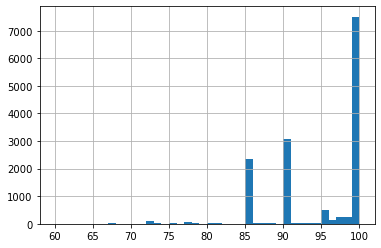

In [66]:
imdb_games["best_fit_ratio"].hist(bins=40)

We can see that we have a lot of values for 85, 90 and 100% matches. We've already ascertained that 90% does not seem to give accurate enough results. We are going to set the ratio at 92.5% (note, that this is done in the cell at the start of the notebook), which should be the best balance for accuracy. Now we remove any data from the merged columns where the ratio was below 92.5%

In [67]:
def remove_nonmatches(row):
    if row.best_fit_ratio < considered_best_fit_ratio:
        row.best_fit_game_id = np.nan
        row.game_id = np.nan
        row.franchise_id = np.nan
        row.developers = np.nan
        row.genres_y = np.nan
        row.platforms = np.nan
        row.publishers = np.nan
        row.rating = np.nan
    return row

In [68]:
imdb_games = imdb_games.apply(remove_nonmatches, axis = 1)

All the games with a very similar match ratio (92.5%) have the relevant franchise_ids applied to their data. The next thing to do will be to extract the franchise_ids match each franchise_id with the franchise name. To do this we need to import the franchise_dataframe

In [71]:
franchise_df = pd.read_csv("raw_data/giantbomb_data/franchise_ids.csv", index_col = 0)
franchise_df.sample()

,guid,name,description
67,3025-1632,Bosconian,NaN


In [72]:
imdb_games.sample()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,genres_x,averageRating,numVotes,all_names_x,...,best_fit_game_id,game_id,franchise_id,name,release_year,developers,genres_y,platforms,publishers,rating
5238549,tt2044752,videoGame,Chester Cheetah: Too Cool to Fool,Chester Cheetah: Too Cool to Fool,0,1992,Action,5.8,13.0,Chester Cheetah: Too Cool to Fool,...,NaN,NaN,NaN,007: Licence to Kill,1989,NaN,NaN,NaN,NaN,NaN


In [73]:
imdb_games = imdb_games.explode("franchise_id")
imdb_games = pd.merge(imdb_games, franchise_df, left_on="franchise_id", right_on="guid", how="left")
imdb_games.sample()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,genres_x,averageRating,numVotes,all_names_x,...,name_x,release_year,developers,genres_y,platforms,publishers,rating,guid,name_y,description
8675,tt1505922,videoGame,Star Wars: The New Droid Army,Star Wars: The New Droid Army,0,2002,"Action,Sci-Fi",5.5,31.0,Star Wars: The New Droid Army,...,Star Wars: The New Droid Army,0,['Helixe'],['Action'],['Game Boy Advance'],['THQ'],['ESRB: E'],3025-4625,Star Wars Prequel Trilogy,NaN


Convert the genres_x to a list

In [74]:
imdb_games["genres_x"] = imdb_games["genres_x"].apply(lambda x: x.split(","))

In [75]:
type(imdb_games.genres_y.iloc[2])

str

In [76]:
#This line may or may not be needed depending on whether the type listed above is str or list (which will depend on how the dataframe was loaded)
imdb_games['genres_y'] = imdb_games["genres_y"].apply(lambda row: ast.literal_eval(row) if pd.notna(row) else np.nan)

Combine the genres columns and drop the extra one. Remove duplicates from each cell

In [77]:
imdb_games["genres_x"] = imdb_games["genres_x"] + imdb_games["genres_y"].fillna("").apply(list)
imdb_games = imdb_games.drop("genres_y", axis = 1)
imdb_games = imdb_games.rename(columns = {"genres_x": "genres"})

In [78]:
imdb_games['genres'] = imdb_games['genres'].apply(lambda x: list(set(x)))

In [79]:
imdb_games.sample()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,genres,averageRating,numVotes,all_names_x,...,franchise_id,name_x,release_year,developers,platforms,publishers,rating,guid,name_y,description
2353,tt0359849,videoGame,Power Instinct,Gôketsuji Ichizoku,0,1993,"[Action, Fighting, Fantasy]",6.6,32.0,Power Instinct,...,3025-434,Power Instinct,1993,"['Atlus', 'A.I Co., Ltd.']","['Genesis', 'Super Nintendo Entertainment Syst...","['Atlus U.S.A., Inc.', 'Atlus']","['ESRB: T', 'CERO: B']",3025-434,Power Instinct,NaN


In [80]:
#Drop unnecessary columns
imdb_games =imdb_games.drop(["originalTitle", "all_names_x", "best_fit_title", "best_fit_game_id", "name_x", "release_year", "description", "guid"],  axis = 1)

In [81]:
#Rename franchise_name column
imdb_games = imdb_games.rename(columns = {"name_y": "franchise_name"})

In [82]:
# Rearrange the titles of the columns so the columns are in a better order:
imdb_games = imdb_games[["franchise_name", "franchise_id", "tconst", "titleType", "primaryTitle", "startYear", "isAdult", "averageRating", "numVotes", "game_id", "best_fit_ratio", "genres", "developers", "platforms", "publishers", "rating"]]
imdb_games.sample()

,franchise_name,franchise_id,tconst,titleType,primaryTitle,startYear,isAdult,averageRating,numVotes,game_id,best_fit_ratio,genres,developers,platforms,publishers,rating
7733,Forgotten Realms,3025-1022,tt1336605,videoGame,Pool of Radiance,1988,0,7.3,34.0,16019.0,100.0,"[Strategy, Role-Playing, Fantasy]","['Strategic Simulations, Inc.']","['Amiga', 'Apple II', 'Commodore 64', 'Mac', '...","['Pony Canyon, Inc.', 'Strategic Simulations, ...","['ESRB: M', 'ESRB: T']"


In [84]:
imdb_games.sort_values("tconst")

,franchise_name,franchise_id,tconst,titleType,primaryTitle,startYear,isAdult,averageRating,numVotes,game_id,best_fit_ratio,genres,developers,platforms,publishers,rating
0,NaN,NaN,tt0084376,videoGame,"MysteryDisc: Murder, Anyone?",1982,0,6.0,38.0,NaN,90.0,"[Crime, Mystery, Adventure]",NaN,NaN,NaN,NaN
1,NaN,NaN,tt0105000,videoGame,Night Trap,1992,0,6.2,378.0,NaN,85.5,"[Mystery, Horror, Adventure]",NaN,NaN,NaN,NaN
2,Gabriel Knight,3025-638,tt0109865,videoGame,Gabriel Knight: Sins of the Fathers,1993,0,9.1,711.0,7821.0,100.0,"[Drama, Horror, Adventure]","['Sierra', 'Phoenix Online Studios', 'Pinkerto...","['Mac', 'PC', 'iPhone', 'iPad', 'Android']","['Sierra', 'Pinkerton Road Studio']",['ESRB: T']
3,King's Quest,3025-413,tt0110267,videoGame,King's Quest VII: The Princeless Bride,1994,0,7.6,206.0,10917.0,100.0,"[Fantasy, Adventure]",['Sierra'],"['Mac', 'PC']",['Sierra'],"['ESRB: E', 'ESRB: K-A', 'ESRB: T']"
4,NaN,NaN,tt0110909,videoGame,Psychic Detective,1995,0,8.5,50.0,NaN,90.0,"[Mystery, Fantasy, Adventure]",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17134,NaN,NaN,tt9888864,videoGame,Infernal,2007,0,6.0,17.0,NaN,90.0,[Action],NaN,NaN,NaN,NaN
17135,NaN,NaN,tt9892552,videoGame,Spiral Splatter,2017,0,2.0,10.0,NaN,85.5,[Action],NaN,NaN,NaN,NaN
17136,NaN,NaN,tt9893348,videoGame,Alien: Covenant In Utero VR Experience,2017,0,6.0,17.0,NaN,90.0,[Sci-Fi],NaN,NaN,NaN,NaN
17137,LEGO,3025-448,tt9893804,videoGame,The Lego Movie 2 Videogame,2019,0,5.5,161.0,22035.0,100.0,"[Animation, Family, Adventure, Action-Adventure]",['TT Games'],"['PC', 'Xbox One', 'PlayStation 4', 'Nintendo ...",['WB Games'],NaN


Export the clean dataset to csv

In [85]:
imdb_games.to_csv("clean_data\clean_games_with_franchises.csv")